In [236]:
import pyarrow.feather as feather
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import requests
import os
import concurrent.futures
import multiprocessing
import tensorflow as tf

In [237]:
df = feather.read_feather('data/artsy_full.feather')

In [238]:
df = df[df['category'] == 'Painting']

In [239]:
df.dropna(subset=['image_versions'], inplace=True)

In [240]:
def convert_to_list(value):
    value = value.tolist()
    
    return value

def get_largest_version(row):
    
    image_versions = row['image_versions']
    
    if 'large' in image_versions:
        version = 'large'
    elif 'medium' in image_versions:
        version = 'medium'
    else:
        version = image_versions[0]
    
    row['main_image_version'] = version
    
    return row
    
df['image_versions'] = df['image_versions'].apply(convert_to_list)
df = df.apply(get_largest_version, axis=1)

In [241]:
df['genes'] = df['genes'].apply(convert_to_list)

In [242]:
all_genes = set()
for idx, row in df.iterrows():
    for gene in row.genes:
        all_genes.add(gene)

In [243]:
len(all_genes)

405

In [244]:
all_genes_dict = dict.fromkeys(all_genes, 0)
for idx, row in df.iterrows():
    for gene in row.genes:
        all_genes_dict[gene] += 1
        


all_genes_dict = {k: v for k, v in sorted(all_genes_dict.items(), key=lambda item: item[1])}

In [245]:
all_genes_dict

{'Splattered/Dripped': 1,
 'Crime': 1,
 'Figurative Sculpture': 1,
 'Ancient Egypt': 1,
 'Layered Images': 1,
 'Minoan Art': 1,
 'Leather/Hide': 1,
 'Suburbia': 1,
 'Mughal Art': 1,
 'Funerary/Commemorative Object': 1,
 'Extreme Angle': 1,
 'Portugal': 1,
 'Stained Glass Effect': 1,
 'Language': 1,
 'Picassoesque': 1,
 'Angular': 1,
 'Turkey': 1,
 'Objets de Vertu': 1,
 'Shallow Depth of Field': 1,
 'Iridescence/Opalescence': 1,
 'Tang Dynasty': 1,
 'Himalayan Art': 1,
 'Mixed-Media': 1,
 'Bowl': 1,
 'Engaged with Pre-Columbian Art': 1,
 'Chalk': 1,
 'Hard-Edged': 1,
 'Hindu Art and Architecture': 1,
 'Social Realism': 1,
 'Design': 1,
 'Hatching': 1,
 'Transparent/Translucent Medium': 1,
 'Gemstone': 1,
 'Roman Art and Architecture': 1,
 'Korea': 1,
 'Ming Dynasty': 1,
 'Engaged with Byzantine and Medieval Art': 1,
 'Portraits without a Face': 1,
 'Institutional Critique': 1,
 'Stains/Washes': 1,
 'Radiating Lines': 1,
 'Appropriation': 1,
 'Flanders and Luxembourg': 1,
 'Indonesian A

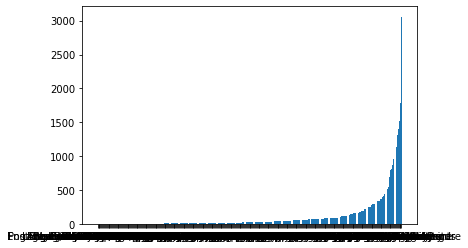

In [109]:
import matplotlib.pyplot as plt

plt.bar(all_genes_dict.keys(), all_genes_dict.values())
plt.show()

In [246]:
genes_simple = {key:all_genes_dict[key] for key in all_genes_dict.keys() if all_genes_dict[key] > 20 and 'Century' not in key and 'Painting' not in key}

In [247]:
genes_simple

{'Cityscapes': 21,
 'References to Art History': 21,
 'Parties and Celebrations': 22,
 'Text': 22,
 'Conflict': 23,
 'Interlaced Bodies': 23,
 'Figures of the Art World': 23,
 'Personal Histories': 23,
 'Violence': 23,
 'Adolescence': 25,
 'Reflections': 25,
 'Gold Leaf and Gilding': 25,
 'Isolation/Alienation': 26,
 'Hudson River School': 26,
 '1000–1400 CE': 27,
 'Provocative': 27,
 'Self-Portrait': 27,
 'Related to Music': 28,
 'The Fantastic': 29,
 'Barbizon School': 29,
 'Face': 29,
 'Erotic': 29,
 'Political Figures': 29,
 'Symbolism': 29,
 'Patterns': 30,
 'Performing Arts': 30,
 'Emphasis on Linear Perspective': 30,
 'Pastel Colors': 31,
 'Hyperrealism': 32,
 'Travel/Tourism': 32,
 'Love': 33,
 'Fresco': 33,
 'Classical Figure': 33,
 'Early Renaissance': 35,
 'Work and Workers': 36,
 'Symbolic Composition': 36,
 'Related to Literature': 36,
 'Germany': 37,
 'American Impressionism': 37,
 'Murals and Wall Drawings': 37,
 'Abstract versus Figurative Art': 37,
 'Antiquity as Subje

In [248]:
gene_cols = list(genes_simple.keys())

In [249]:
df[gene_cols] = 0    

/var/folders/jy/34vkbxz97tbgm78bc07fmx380000gn/T/ipykernel_66080/4254563620.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[gene_cols] = 0
/var/folders/jy/34vkbxz97tbgm78bc07fmx380000gn/T/ipykernel_66080/4254563620.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[gene_cols] = 0
/var/folders/jy/34vkbxz97tbgm78bc07fmx380000gn/T/ipykernel_66080/4254563620.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider join

In [250]:
def one_hot_genes(row):
    for gene in row.genes:
        if gene in gene_cols:
            row[gene] = 1
    return row

df = df.apply(one_hot_genes, axis=1)

In [251]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

transform = PowerTransformer()

X = df.drop(columns=gene_cols)
y = np.array(df[gene_cols])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [252]:
X_train.reset_index(inplace=True)
# y_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True)
# y_val.reset_index(inplace=True, drop=True)

In [253]:
class ImageDownloader:
    
    def __init__(self):
        pass
        
    def download(self, df, subset_string):
        self.df = df
        self.subset_string = subset_string
        self.bad_link = []
        
        try:
            path = './images'
            os.mkdir(path)
        except:
            pass
        try:
            os.mkdir(path+'/'+subset_string)
        except:
            pass
        try:
            os.mkdir(path+'/'+subset_string+'/0')
        except:
            pass
        
        
        self.image_dir = path+'/'+subset_string

        max_threads = 10
        threads = min(max_threads, len(df))

        indexes = df.index

        with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
            executor.map(self._download_imgs_for_set, indexes)
            
        return self
            
    def _download_imgs_for_set(self, index):

        row = self.df.iloc[index]
        filename = f'{str(index).zfill(5)}.jpg'
        path = f'images/{self.subset_string}/0/{filename}'

        img_data = requests.get(row.image_link.replace('{image_version}', row.main_image_version))
        if img_data.ok:
            with open(path, 'wb') as handler:
                handler.write(img_data.content)
        else:
            self.bad_link.append(index)
        
        
            
            

In [254]:
train_downloader = ImageDownloader()
train_downloader.download(X_train, 'train')
val_downloader = ImageDownloader()
val_downloader.download(X_val, 'val')

In [255]:
batch_size = 32
img_width = 224
img_height = 224

train_ds = tf.keras.utils.image_dataset_from_directory(directory=train_downloader.image_dir,
                                                       labels=list(y_train), validation_split=0.2,
                                                       subset='training',
                                                       seed=42,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                      shuffle=False)

val_ds = tf.keras.utils.image_dataset_from_directory(directory=val_downloader.image_dir,
                                                     labels=list(y_val), validation_split=0.2,
                                                     subset='validation',
                                                     seed=42,
                                                     image_size=(img_height, img_width),
                                                     batch_size=batch_size,
                                                    shuffle=False)

Found 1879 files belonging to 1 classes.
Using 1504 files for training.
Found 470 files belonging to 1 classes.
Using 94 files for validation.


In [256]:
num_outputs = len(y[0])

In [274]:
def augment_using_ops(images, labels):
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    images = tf.image.rot90(images)
    return (images, labels)

train_ds = train_ds.cache().map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [275]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras import layers



model = Sequential([
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten(),
    Dense(units=4096,activation="relu"),
    Dense(units=4096,activation="relu"),
    Dense(units=num_outputs, activation='sigmoid')
])



model_simple = Sequential([
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten(),
    Dense(units=4096,activation="relu"),
    Dense(units=num_outputs, activation='sigmoid')
])


In [276]:
steps_per_epoch = 1504//batch_size

validation_steps = 94//batch_size


In [281]:
from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(learning_rate=0.001)
model_simple.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early = EarlyStopping(monitor='acc', min_delta=0, patience=20, verbose=1, mode='auto')

hist = model_simple.fit(train_ds.repeat(),
                        steps_per_epoch=steps_per_epoch,
                        epochs=200,
                        validation_data=val_ds,
                        validation_steps=validation_steps,
                        callbacks=[early])


Epoch 1/200


2022-08-02 22:11:12.136357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 30.8219 - acc: 0.0000e+00

2022-08-02 22:11:45.046777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 34s 686ms/step - loss: 30.8219 - acc: 0.0000e+00 - val_loss: 0.1543 - val_acc: 0.0000e+00
Epoch 2/200
47/47 [==============================] - 31s 668ms/step - loss: 0.2135 - acc: 0.0000e+00 - val_loss: 0.1266 - val_acc: 0.0000e+00
Epoch 3/200
47/47 [==============================] - 31s 666ms/step - loss: 0.2170 - acc: 0.0000e+00 - val_loss: 0.1373 - val_acc: 0.0000e+00
Epoch 4/200
47/47 [==============================] - 31s 664ms/step - loss: 0.2042 - acc: 0.0000e+00 - val_loss: 0.1280 - val_acc: 0.0000e+00
Epoch 5/200
47/47 [==============================] - 32s 670ms/step - loss: 0.2050 - acc: 0.0000e+00 - val_loss: 0.1188 - val_acc: 0.0000e+00
Epoch 6/200
47/47 [==============================] - 32s 670ms/step - loss: 0.1751 - acc: 0.0000e+00 - val_loss: 0.1356 - val_acc: 0.0000e+00
Epoch 7/200
47/47 [==============================] - 32s 670ms/step - loss: 0.1766 - acc: 0.0000e+00 - val_loss: 0.1582 - val_acc: 0.0000e+00
Epoch 8/200
47/47

47/47 [==============================] - 31s 655ms/step - loss: 0.0445 - acc: 0.0971 - val_loss: 0.4478 - val_acc: 0.0000e+00
Epoch 61/200
47/47 [==============================] - 31s 658ms/step - loss: 0.0442 - acc: 0.0977 - val_loss: 0.4560 - val_acc: 0.0000e+00
Epoch 62/200
47/47 [==============================] - 31s 661ms/step - loss: 0.0428 - acc: 0.1117 - val_loss: 0.4485 - val_acc: 0.0000e+00
Epoch 63/200
47/47 [==============================] - 31s 661ms/step - loss: 0.0504 - acc: 0.0984 - val_loss: 0.3726 - val_acc: 0.0000e+00
Epoch 64/200
47/47 [==============================] - 31s 657ms/step - loss: 0.0601 - acc: 0.0951 - val_loss: 0.3788 - val_acc: 0.0000e+00
Epoch 65/200
47/47 [==============================] - 31s 659ms/step - loss: 0.0359 - acc: 0.0971 - val_loss: 0.5457 - val_acc: 0.0156
Epoch 66/200
47/47 [==============================] - 31s 667ms/step - loss: 0.0389 - acc: 0.1070 - val_loss: 0.3417 - val_acc: 0.0156
Epoch 67/200
47/47 [============================